In [1]:
import perfplot
from tanimoto import tanimoto_similarity
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

In [2]:
def smi2fp(smile, radius=2, n_bits=2048):
    """Convert SMILES string to Morgan fingerprint."""
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return np.zeros(n_bits)  # Return a zero vector for invalid SMILES
    fp = mfpgen.GetFingerprint(mol)
    return fp

def create_zinc_fps():
    with open("zinc20k.csv", "r") as f:
        smiles = f.read().splitlines()

    return [smi2fp(smi) for smi in smiles]

In [3]:
simple = [
    "CCO",  # Ethanol
    "CCC",  # Propane
    "CCN",  # Ethylamine
    "CCOCC",  # Diethyl ether
    "CC(=O)O",  # Acetate
    "CCOCCO",  # Ethylene glycol diethyl ether
    "CC(C)O",  # Isopropanol
    "C1CCCCC1",  # Cyclohexane
    "C1=CC=CC=C1",  # Benzene
    "CC(C)C",  # Isobutane
]

SIMPLE_FPS = [smi2fp(smi) for smi in simple]
FPS = create_zinc_fps()

In [4]:
import torch
A = np.array([list(fp) for fp in SIMPLE_FPS], dtype=np.bool_)
B = np.array([list(fp) for fp in FPS], dtype=np.bool_)
At = torch.tensor([list(fp) for fp in SIMPLE_FPS]).bool()
Bt = torch.tensor([list(fp) for fp in FPS]).bool()

Output()

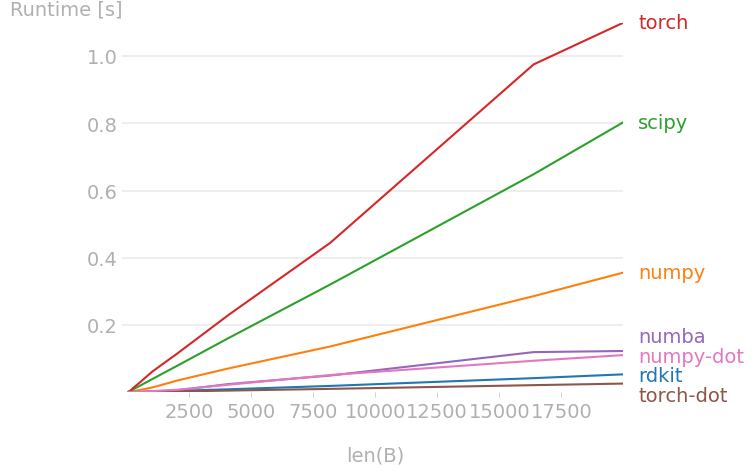

In [5]:
ns = [2**k for k in range(4, 15)] + [len(FPS)]

out = perfplot.show(
    setup=lambda n: n,
    kernels=[
        lambda n: tanimoto_similarity(SIMPLE_FPS, FPS[:n], method="rdkit", convert=False),
        lambda n: tanimoto_similarity(A[:n, :], B[:n, :], method="numpy", convert=False),
        lambda n: tanimoto_similarity(A[:n, :], B[:n, :], method="scipy", convert=False),
        lambda n: tanimoto_similarity(At[:n, :], Bt[:n, :], method="torch", convert=False),
        #lambda n: tanimoto_similarity(At[:n, :], Bt[:n, :], method="torch-compile", convert=False),
        lambda n: tanimoto_similarity(At[:n, :].float(), Bt[:n, :].float(), method="torch-dot", convert=False),
        lambda n: tanimoto_similarity(A[:n, :], B[:n, :], method="numba", convert=False),
        lambda n: tanimoto_similarity(A[:n, :].astype(np.float32), B[:n, :].astype(np.float32), method="numpy-dot", convert=False),
    ],
    labels=["rdkit", "numpy", "scipy", "torch", "numba", "torch-dot", "numpy-dot"],
    n_range=ns,
    xlabel="len(B)",
    logx=False
)